In [1]:
# Matrix Manipulation/Management Libraries
import pandas as pd

# Data Visualization Libaries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Input/Output Libraries
import os
import subprocess

# Bioinformatics Libraries
import pybedtools

# Statistical Tests, Machine Learning, etc. Libraries
import igraph as ig

# Miscellaneous Libraries 
import time

In [ ]:
def label_clusters(cluster: list):
    # Enhancer --> Gene (1:1), Clusters with 2 Nodes
    if len(cluster) == 2:
        return "Enhancer --> Gene (1:1)"
    
    # Enhancers --> Gene (2+:1) OR Enhancer --> Genes (1:2+), Clusters with 2+ Nodes Containing 1 Module/Gene
    elif len(cluster) > 2:
        module_count = 0
        gene_count = 0
        for item in cluster:
            if item.startswith("Module_"):
                module_count += 1
            else:
                gene_count += 1
        if module_count == len(cluster) - 1:
            return "Enhancers --> Gene (2+:1)" 
        elif gene_count == len(cluster) - 1:
            return "Enhancer --> Genes (1:2+)"
    
    # Enhancers --> Genes (2+:2+), Remaining Clusters
    return "Enhancers --> Genes (2+:2+)"

In [ ]:
def cluster_distribution(clusters: dict):
    
    # Define Substructures 
    distribution = {"Enhancer --> Gene (1:1)": 0, "Enhancers --> Gene (2+:1)": 0, "Enhancer --> Genes (1:2+)": 0, "Enhancers --> Genes (2+:2+)": 0}
    total_clusters = 0
    
    # Count Each Substructure
    for cluster in clusters.values():
        label = label_clusters(cluster)
        distribution[label] += 1
        total_clusters += 1
    
    # Print Values 
    for label, count in distribution.items():
        print(f"{label}: {count/total_clusters*100:.2f}%")

In [ ]:
def cluster_betweenness(file_name: str):
    
    # Create Bipartite Network 
    df = pd.read_csv(file_name, sep = '\t')
    df = df.loc[:, ["Module", "Gene"]]
    df = df.drop_duplicates()
    
    # Convert Network to iGraph Object
    tuples = [tuple(x) for x in df.values]
    g = ig.Graph.TupleList(tuples, directed = True)
    node_labels = g.vs['name']
    
    # Cluster Network Betweenness, Generate iGraph Communities
    communities = g.community_edge_betweenness().as_clustering()
    
    # Store Clusters, Label Nodes
    communities_dict = {}
    
    for i, c in enumerate(communities):
        for node_index in c:
            communities_dict[node_labels[node_index]] = i
            
    clusteres = {}
    for key, value in communities_dict.items():
        clusteres.setdefault(value, []).append(key)
        
    return clusteres

In [ ]:
# Substructures for Collapsed Network

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/MPRA_Network_Filtered_Edges.tsv'))

In [ ]:
# Substructures for Timepoint-Specific Network (0 Hours)

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/0h_sample.ABC_Network_Filtered_Edges.tsv'))

In [ ]:
# Substructures for Timepoint-Specific Network (3 Hours)

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/3h_sample.ABC_Network_Filtered_Edges.tsv'))

In [ ]:
# Substructures for Timepoint-Specific Network (6 Hours)

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/6h_sample.ABC_Network_Filtered_Edges.tsv'))

In [ ]:
# Substructures for Timepoint-Specific Network (12 Hours)

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/12h_sample.ABC_Network_Filtered_Edges.tsv'))

In [ ]:
# Substructures for Timepoint-Specific Network (24 Hours)

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/24h_sample.ABC_Network_Filtered_Edges.tsv'))

In [ ]:
# Substructures for Timepoint-Specific Network (48 Hours)

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/48h_sample.ABC_Network_Filtered_Edges.tsv'))

In [ ]:
# Substructures for Timepoint-Specific Network (72 Hours)

cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/72h_sample.ABC_Network_Filtered_Edges.tsv'))

In [ ]:
def permutation_regions(filtered: str, unfiltered: str, variants: str, n_permutations: int):
    
    # Load .bed Files into Permutation Test
    filtered = pybedtools.BedTool(filtered).sort().merge()
    unfiltered = pybedtools.BedTool(unfiltered).sort().merge()
    variants = pybedtools.BedTool(variants).sort().merge()
    
    # Calculate Modules (Enhancers) within Filtered .bed File
    n_filtered = len(filtered)
    
    # Store Intersections for Random Instances 
    intersections = []
    
    # Preform Premutation Test
    for i in range(n_permutations):
        # Generate Random .bed Files from Unfiltered .bed File
        seed = int(time.time() * 1000) % (2**32 - 1)
        random = unfiltered.shuffle(genome="hg19", chrom = True, seed = seed).saveas("random.bed")
        random = pybedtools.BedTool(iter(random[:n_filtered]))
        
        # Count Intersections in Random Instances
        intersected = random.intersect(variants, u=True)
        n_intersected = len(intersected)
        intersections.append(n_intersected)

    # Counts Filtered .bed Hits
    n_filtered = len(filtered.intersect(variants))

    # Calculate Average Random .bed File Hits
    mean_hits = (sum(intersections) / len(intersections))

    # Calculate Significance of Filtered .bed File's Hits
    counter = 0
    for i in intersections:
        if i >= n_filtered:
            counter += 1
    FDR = (counter / len(intersections))
    
    # Plot Histogram of Random Instance Hits
    fig, ax = plt.subplots()
    ax.hist(intersections, bins=20, color='#59B3DC')
    ax.axvline(x=n_filtered, color='#cc0000', linestyle='-')
    ax.set_xlabel('Intersections with ASD-Associated SNPs')
    ax.set_ylabel('Frequency')
    ax.set_title('Autism Spectrum Disorder Variant Enrichment Permutation Test')
    plt.show()

    # Print Results
    print("Regions Tested: ", len(filtered))
    print("Variant Hits: ", n_filtered)
    print("Random Average Hits: ", mean_hits)
    print("FDR: ", FDR)

In [ ]:
def permutation_genes(filtered: str, unfiltered: str, variants: str, n_permutations: int):
    
    # Load Gene lists into Permutation Test
    filtered = pd.read_csv(filtered, sep = '\t')
    filtered = filtered[['Gene']]
    filtered = filtered.drop_duplicates()

    
    unfiltered = pd.read_csv(unfiltered, sep = '\t')
    unfiltered = unfiltered[['Gene']]
    unfiltered = unfiltered.drop_duplicates()
    
    
    variants = pd.read_csv(variants, sep = '\t')
    variants = variants[['Gene']]
    variants = variants.drop_duplicates()
    
    # Calculate Genes within Filtered List
    n_filtered = len(filtered)
    
    # Store Intersections for Random Instances 
    intersections = []
    
    # Preform Premutation Test
    for i in range(n_permutations):
        # Generate Random Gene List from Unfiltered List
        random = unfiltered.sample(n = n_filtered, replace = False)
        
        # Count Intersections in Random Instances
        intersected = pd.merge(random, variants, on = 'Gene')
        n_intersected = len(intersected)
        intersections.append(n_intersected)

    # Counts Filtered Gene List
    n_filtered = len(pd.merge(filtered, variants, on='Gene'))

    # Calculate Average Random .bed File Hits
    mean_hits = (sum(intersections) / len(intersections))

    # Calculate Significance of Filtered Gene List's Hit
    counter = 0
    for i in intersections:
        if i >= n_filtered:
            counter += 1
    FDR = (counter / len(intersections))
        
    # Plot Histogram of Random Instance Hits
    fig, ax = plt.subplots()
    ax.hist(intersections, bins=20, color='#59B3DC')
    ax.axvline(x=n_filtered, color='#cc0000', linestyle='-')
    ax.set_xlabel('Intersection with ASD-Associated Genes')
    ax.set_ylabel('Frequency')
    ax.set_title('Autism Spectrum Disorder Gene Enrichment Permutation Test')
    plt.show()
    
    # Print results
    print("Genes Tested: ", len(filtered))
    print("Variant Hits: ", n_filtered)
    print("Random average Hits: ", mean_hits)
    print("FDR: ", FDR)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Collapsed Network

permutation_regions("/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Timepoint 0h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/0h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Timepoint 3h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/3h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Timepoint 6h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/6h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Timepoint 12h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/12h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Timepoint 24h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/24h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Timepoint 48h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/48h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Timepoint 72h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/72h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed", 100)

In [ ]:
# GWAS NDD Variants Permutation Test, Collapsed Network

permutation_regions("/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# GWAS NDD Variants Permutation Test, Timepoint 0h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/0h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# GWAS NDD Variants Permutation Test, Timepoint 3h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/3h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# GWAS NDD Variants Permutation Test, Timepoint 6h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/6h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# GWAS NDD Variants Variants Permutation Test, Timepoint 12h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/12h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# GWAS NDD Variants Permutation Test, Timepoint 24h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/24h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# GWAS NDD Variants Permutation Test, Timepoint 48h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/48h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# GWAS NDD Variants Permutation Test, Timepoint 72h

permutation_regions("/home/wbd20/Kreimer_Lab/Network/Timepoints/BED/72h_sample.ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/Neuro_Disorders_Pe7_NoEAiqNeuroticism.bed", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Collapsed Network

permutation_genes("/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Timepoint 0h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/0h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Timepoint 3h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/3h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Timepoint 6h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/6h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Timepoint 12h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/12h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Timepoint 24h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/24h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Timepoint 72h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/72h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# Autism Spectrum Disorder Genetic Variants, Timepoint 48h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/48h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Collapsed Network

permutation_genes("/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Timepoint 0h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/0h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Timepoint 3h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/3h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Timepoint 6h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/6h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Timepoint 12h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/12h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Timepoint 24h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/24h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Timepoint 48h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/48h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
# NDD Genetic Variants, Timepoint 72h

permutation_genes("/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/72h_sample.ABC_Network_Filtered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Edges.tsv",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/NDD_Genes.tsv", 100)

In [ ]:
NW = pybedtools.BedTool('/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Regions.bed')
ASD_Variants = pybedtools.BedTool('/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed')

NW.intersect(ASD_Variants, wo=True, output = '/home/wbd20/Kreimer_Lab/Network/NW_ASD.bed')

cols = ['Chrom', 'Start', 'End', 'Chrom1', 'Start1', 'End1','Else']
NW_ASD = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/NW_ASD.bed', sep = '\t', names = cols)
NW_ASD = NW_ASD[['Chrom', 'Start', 'End']]
NW_Filtered = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Edges.tsv', sep = '\t')
NW_Filtered = NW_Filtered.drop('Module', axis = 1)
NW_Filtered = NW_Filtered.drop('Sample', axis = 1)
ASD_Genes = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/Variants/ASD_Genes.tsv', sep = '\t')
NW_Filtered = NW_Filtered.merge(NW_ASD, on=["Chrom","Start", 'End'])
NW_Filtered = NW_Filtered.merge(ASD_Genes, on = 'Gene', how = 'inner')
NW_Filtered = NW_Filtered[['Chrom', 'Start', 'End', 'Gene']]

NW_Filtered.to_csv('/home/wbd20/Kreimer_Lab/Network/NW_ASD_Cluster.tsv', sep = '\t', index = None)
cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/NW_ASD_Cluster.tsv'))

In [ ]:
NW = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/NW_ASD_Cluster.tsv', sep = '\t')
NW
#cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/NW_ASD_Cluster.tsv'))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df['Module_Gene'] = df['Module'] + '_' + df['Gene']

matrix = [[0 for _ in range(7)] for _ in range(7)]

for i in range(7):
    for j in range(i, 7):
        time1 = set(df[df['Sample'] == f'{i}h_sample']['Module_Gene'])
        time2 = set(df[df['Sample'] == f'{j}h_sample']['Module_Gene'])
        intersection = len(time1 - time2)
        union = len(time1 | time2)
        score = 0 if union == 0 else intersection / union
        matrix[i][j] = score
        matrix[j][i] = score

labels = ['0', '3', '6', '12', '24', '48', '72']
sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set font family and font size
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['font.size'] = 12

# Data
labels = ['Enhancer --> Gene (1:1)', 'Enhancers --> Gene (2+:1)', 'Enhancer --> Genes (1:2+)', 'Enhancers --> Genes (2+:2+)']
sizes = [33.59, 4.97, 39.67, 21.77]
colors = ['#F44336', '#FFA500', '#4CAF50', '#ADD8E6']  # Set colors

# Pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)  # Use colors parameter
ax.axis('equal')
plt.show()

In [ ]:
df1 = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/0h_sample.ABC_Network_Filtered_Edges.tsv', sep = '\t')
df2 = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/Timepoints/Tables/72h_sample.ABC_Network_Filtered_Edges.tsv', sep = '\t')
genes_df1 = set(df1['Gene'])
genes_df2 = set(df2['Gene'])
genes_only_in_df2 = list(genes_df2 - genes_df1)

with open('/home/wbd20/Kreimer_Lab/Network/genes_only_in_df2.txt', 'w') as f:
    for gene in genes_only_in_df2:
        f.write(gene + '\n')

In [ ]:
NW = pybedtools.BedTool('/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Regions.bed')
ASD_Variants = pybedtools.BedTool('/home/wbd20/Kreimer_Lab/Network/Variants/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed')

NW.intersect(ASD_Variants, wo=True, output = '/home/wbd20/Kreimer_Lab/Network/NW_ASD.bed')

cols = ['Chrom', 'Start', 'End', 'Chrom1', 'Start1', 'End1','Else']
NW_ASD = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/NW_ASD.bed', sep = '\t', names = cols)
NW_ASD = NW_ASD[['Chrom', 'Start', 'End']]
NW_Filtered = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Edges.tsv', sep = '\t')
NW_Filtered = NW_Filtered.merge(NW_ASD, on=["Chrom","Start", 'End'])
NW_Filtered = NW_Filtered.drop('Sample', axis = 1)
NW_Filtered = NW_Filtered.drop('Chrom', axis = 1)
NW_Filtered = NW_Filtered.drop('Start', axis = 1)
NW_Filtered = NW_Filtered.drop('End', axis = 1)


NW_Filtered.to_csv('/home/wbd20/Kreimer_Lab/Network/NW_ASD_Cluster.tsv', sep = '\t', index = None)
cluster_distribution(cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/NW_ASD_Cluster.tsv'))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Time Point': ['Collapsed','0 Hours', '3 Hours', '6 Hours', '12 Hours', '24 Hours', '48 Hours', '72 Hours'],
    'Enhancer -> Gene (1:1)': [33.59, 28.27, 29.02, 29.68, 28.82, 29.91, 28.34, 29.53],
    'Enhancers -> Gene (2+:1)': [4.97, 2.55, 2.10, 1.94, 2.66, 2.68, 2.09, 2.82],
    'Enhancer -> Genes (1:2+)': [39.67, 49.59, 50.47, 49.66, 49.31, 47.88, 48.22, 46.85],
    'Enhancers -> Genes (2+:2+)': [21.77, 19.58, 18.41, 18.72, 19.21, 19.53, 21.35, 20.80]
}

df = pd.DataFrame(data)

# Set the new color scheme
colors = ['#004982', '#59B3DC', '#85C7E6', '#BFD9F2']

plt.figure(figsize=(10, 6))
plt.bar(df['Time Point'], df['Enhancer -> Gene (1:1)'], color=colors[0], label='Enhancer -> Gene (1:1)')
plt.bar(df['Time Point'], df['Enhancers -> Gene (2+:1)'], bottom=df['Enhancer -> Gene (1:1)'],
        color=colors[1], label='Enhancers -> Gene (2+:1)')
plt.bar(df['Time Point'], df['Enhancer -> Genes (1:2+)'], bottom=df['Enhancer -> Gene (1:1)']+df['Enhancers -> Gene (2+:1)'],
        color=colors[2], label='Enhancer -> Genes (1:2+)')
plt.bar(df['Time Point'], df['Enhancers -> Genes (2+:2+)'], bottom=df['Enhancer -> Gene (1:1)']+df['Enhancers -> Gene (2+:1)']+df['Enhancer -> Genes (1:2+)'],
        color=colors[3], label='Enhancers -> Genes (2+:2+)')
plt.xlabel('Time Point')
plt.ylabel('Substructure Composition')
plt.title('Enhancer-Promoter Interactions Substructure Across Time Points')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig('enhancer_gene_interaction.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


In [ ]:
ZNF219

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Input data
labels = ['Transcriptional Repressor Complex', 'Beta-Catenin-TCF Complex Assembly', 'Negative Regulation of pro-B Cell Differentiation', 'Primary Neural Tube Formation', 'Neural Tube Closure', 'Ventral Spinal Cord Interneuron Specification', 'Tube Closure', 'Mitochondrial Outer Membrane Permeabilization', 'Regulation of Timing of Cell Differentiation', 'Ventral Spinal Cord Interneuron Fate Commitment']
values = [2.2957e-4, 1.936e-4, 9.847e-5, 7.0418e-5, 3.9623e-5, 3.2214e-5, 2.8859e-5, 2.1315e-5, 9.0363e-7, 2.8984e-9]

# Standardize using -log10
values = [-np.log10(x) for x in values]

# Sort values and labels in ascending order
values_sorted, labels_sorted = zip(*sorted(zip(values, labels)))
values_sorted = sorted(values, reverse=True)

# Create horizontal bar chart
plt.barh(range(len(values)), values_sorted, color='#004982')

# Set y-axis labels
plt.yticks(range(len(values)), labels_sorted)

# Invert y-axis
plt.gca().invert_yaxis()

# Set x-axis label
plt.xlabel('-log10(Binom Raw P-Value)')

# Set chart title
plt.title('Reconstructed Network Gene Ontology, GREAT')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Input data
labels = ['Transcription Regulator Activity',
          'DNA Binding Transcription Factor Activity',
          'Chromosome',
          'Chromatin',
          'Positive Regulation of Transcription by RNA Polymerase II',]
values = [316, 364, 377, 441, 456]

# Standardize using -log10
#values = [-np.log10(x) for x in values]

# Sort values and labels in ascending order
values_sorted, labels_sorted = zip(*sorted(zip(values, labels)))
values_sorted = sorted(values, reverse=True)

# Create horizontal bar chart
fig, ax = plt.subplots()
bars = ax.barh(range(len(values)), values_sorted, color='#004982')

# Set y-axis labels
plt.yticks(range(len(values)), labels_sorted)

# Invert y-axis
plt.gca().invert_yaxis()

# Set x-axis label
plt.xlabel('Set Coverage')

# Set chart title
plt.title('Collapsed Network Motifs Gene Ontology, GSEA')

# Set the background color of the figure to white
fig.set_facecolor('white')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

colors = ['#004982', '#85C7E6', '#BFD9F2']
data = [35.71, 63.49, 0.79]
labels = ['', '', '']

plt.pie(data, colors=colors, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Austim Spectrum Disorder Variant Regions Substructure Distrubtion')
plt.show()

In [ ]:
hg19 = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/Motifs/hg19_motifs.tsv', sep = '\t')
hg19 = hg19['motif_id'].str.split('_').str.get(0)
hg19 = hg19.drop_duplicates()
hg19 = pd.DataFrame(hg19)
hg19

encode = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/Motifs/encode_motifs.tsv', sep = '\t')
encode = encode['motif_id'].str.split('_').str.get(0)
encode = encode.drop_duplicates()
encode = pd.DataFrame(encode)


motifs = pd.concat([hg19, encode])
motifs = motifs.drop_duplicates()
motifs.to_csv('/home/wbd20/Kreimer_Lab/Network/motifs_gsea.txt', sep = '\t', index = None)

In [ ]:
def cluster_betweenness(file_name: str):
    
    # Create Bipartite Network 
    df = pd.read_csv(file_name, sep = '\t')
    df = df.loc[:, ["Module", "Gene"]]
    df = df.drop_duplicates()
    
    # Convert Network to iGraph Object
    tuples = [tuple(x) for x in df.values]
    g = ig.Graph.TupleList(tuples, directed = True)
    node_labels = g.vs['name']
    
    # Cluster Network Betweenness, Generate iGraph Communities
    communities = g.community_edge_betweenness().as_clustering()
    
    return communities

In [ ]:
# Substructures for Collapsed Network

hello = (cluster_betweenness('/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Edges.tsv'))

In [ ]:
graph = hello.graph

In [ ]:
from IPython.display import SVG, display

In [ ]:
def plot_igraph(graph, layout=None, **kwargs):
    if layout is None:
        layout = graph.layout("auto")
    visual_style = dict()
    visual_style["bbox"] = (400, 400)
    visual_style["margin"] = 20
    visual_style["vertex_size"] = 20
    visual_style["vertex_label_dist"] = 1
    visual_style["edge_width"] = 1
    visual_style["layout"] = layout
    visual_style.update(kwargs)

    plot_obj = ig.plot(graph, **visual_style)
    plot_obj.save("temp_svg_plot.svg")
    
    with open("temp_svg_plot.svg", "r") as f:
        svg_string = f.read()

    return svg_string


In [ ]:
display(SVG(plot_igraph(graph)))

In [ ]:
import igraph as ig

# Create a bipartite graph
    # Create Bipartite Network 
df = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Edges.tsv', sep = '\t')
df = df.loc[:, ["Module", "Gene"]]
df = df.drop_duplicates()
    
    # Convert Network to iGraph Object
tuples = [tuple(x) for x in df.values]
g = ig.Graph.TupleList(tuples, directed = True)
node_labels = g.vs['name']

# Visualize the graph
layout = g.layout_bipartite()
ig.plot(g, layout=layout)

In [2]:
hg19 = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/Motifs/hg19_motifs.tsv', sep='\t')
hg19['motif_id'] = hg19['motif_id'].str.split('_').str.get(0)
hg19 = hg19[['motif_id', 'sequence_name']]
hg19 = hg19.drop_duplicates()
hg19 = hg19.rename(columns={'motif_id': 'TF'})
hg19[['Chrom', 'Start_End']] = hg19['sequence_name'].str.split(':', expand=True)
hg19[['End', 'Strand']] = hg19['Start_End'].str.split('(', expand=True)
hg19[['Start', 'End']] = hg19['End'].str.split('-', expand=True)
hg19 = hg19[[ 'Chrom', 'Start', 'End', 'TF']]
hg19 = hg19.drop_duplicates()

hg19

,Chrom,Start,End,TF
0,chr2,73510811,73512124,ZNF263
1,chr1,244211274,244212811,EGR3
2,chr14,104614953,104618130,ZNF263
3,chr17,63542076,63542947,RELA
4,chr1,244211274,244212811,SP9
...,...,...,...,...
359862,chr11,61582426,61583220,PAX9
359864,chr2,60777264,60778158,MGA
359865,chr9,90993873,90994695,ESR2
359869,chr19,13262242,13263032,TEAD1


In [3]:
encode = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/Motifs/encode_motifs.tsv', sep='\t')
encode['motif_id'] = encode['motif_id'].str.split('_').str.get(0)
encode = encode[['motif_id', 'sequence_name']]
encode = encode.drop_duplicates()
encode = encode.rename(columns={'motif_id': 'TF'})
encode[['Chrom', 'Start_End']] = encode['sequence_name'].str.split(':', expand=True)
encode[['End', 'Strand']] = encode['Start_End'].str.split('(', expand=True)
encode[['Start', 'End']] = encode['End'].str.split('-', expand=True)
encode = encode[[ 'Chrom', 'Start', 'End', 'TF']]
encode = encode.drop_duplicates()

encode

,Chrom,Start,End,TF
0,chr14,21571789,21572429,EGR1
1,chr9,107730371,107731848,EGR1
2,chr6,52929540,52930663,EGR1
3,chr7,112090533,112091417,SETDB1
4,chr2,37551323,37552392,EGR1
...,...,...,...,...
284726,chr1,32705033,32706318,TFAP2
284730,chr15,35312153,35313178,FOXC1
284733,chr2,60777264,60778158,MGA
284734,chr6,151710666,151711938,PDX1


In [4]:
tfs = pd.concat([hg19, encode])
tfs = tfs.drop_duplicates()
tfs

,Chrom,Start,End,TF
0,chr2,73510811,73512124,ZNF263
1,chr1,244211274,244212811,EGR3
2,chr14,104614953,104618130,ZNF263
3,chr17,63542076,63542947,RELA
4,chr1,244211274,244212811,SP9
...,...,...,...,...
284723,chr14,65801387,65801887,RREB1
284725,chr19,54483400,54484752,RREB1
284726,chr1,32705033,32706318,TFAP2
284730,chr15,35312153,35313178,FOXC1


In [5]:
df = pd.read_csv('/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Edges.tsv', sep = '\t')
df[['Start', 'End']] = df[['Start', 'End']].astype(str)
tfs_df = pd.merge(tfs, df, on=['Chrom', 'Start', 'End'])
tfs_df = pd.merge(tfs, df, on = ['Chrom', 'Start', 'End'])
tfs_df = tfs_df.drop_duplicates()

In [6]:
tfs_df

,Chrom,Start,End,TF,Module,Gene,Sample
0,chr2,73510811,73512124,ZNF263,Module_20343,SMYD5,24h_sample
1,chr2,73510811,73512124,ZNF263,Module_20343,SMYD5,12h_sample
2,chr2,73510811,73512124,ZNF263,Module_20343,SMYD5,48h_sample
3,chr2,73510811,73512124,ZNF263,Module_20343,SMYD5,3h_sample
4,chr2,73510811,73512124,ZNF263,Module_20343,SMYD5,72h_sample
...,...,...,...,...,...,...,...
1731698,chr10,119829528,119830124,ZBTB3,Module_5205,RAB11FIP2,72h_sample
1731699,chr10,119829528,119830124,PAX5,Module_5205,RAB11FIP2,48h_sample
1731700,chr10,119829528,119830124,PAX5,Module_5205,RAB11FIP2,72h_sample
1731701,chr10,119829528,119830124,PAX6,Module_5205,RAB11FIP2,48h_sample


In [7]:
df_grouped = tfs_df.groupby(['Module', 'TF']).size()

# now calculate the mean of these counts
average_TF_count_per_module = df_grouped.mean()

print(f'The average count of TFs binding to each module is: {average_TF_count_per_module}')

The average count of TFs binding to each module is: 12.128215543867267


In [ ]:
df = tfs_df
df = df[['TF', 'Sample']]
df = df.drop_duplicates()

# Create a pivot table to calculate the Jaccard scores
pivot = df.pivot_table(index='TF', columns='Sample', aggfunc=lambda x: len(set(x)), fill_value=0)

# Convert the pivot table to a Jaccard similarity matrix
jaccard = pivot.apply(lambda x: pd.Series(1, index=x.index) - pd.Series(x.values, index=x.index))
jaccard = jaccard.T.dot(jaccard)

# Plot the heatmap using seaborn
sns.heatmap(jaccard, cmap='Blues', annot=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data into pandas DataFrame
data = pd.read_csv('file.csv')

# Calculate Jaccard score
samples = data['Sample'].unique()
scores = []
for i in range(len(samples)):
    row = []
    for j in range(len(samples)):
        if i <= j:
            continue
        a = set(data[data['Sample'] == samples[i]]['TF'])
        b = set(data[data['Sample'] == samples[j]]['TF'])
        score = len(a & b) / len(a | b)
        row.append(score)
    scores.append(row)

# Create a matrix of Jaccard scores
matrix = np.zeros((len(samples), len(samples)))
for i in range(len(scores)):
    for j in range(len(scores[i])):
        matrix[i, i+j+1] = scores[i][j]

# Set the sample order
sample_order = ['0h_sample', '3h_sample', '6h_sample', '12h_sample', '24h_sample', '48h_sample', '72h_sample']
matrix = matrix[[np.where(samples == s)[0][0] for s in sample_order], :][:, [np.where(samples == s)[0][0] for s in sample_order]]

# Create a heatmap
plt.imshow(matrix, cmap='Blues')
plt.xticks(range(len(sample_order)), sample_order, rotation=45, ha='right')
plt.yticks(range(len(sample_order)), sample_order)
plt.colorbar()
plt.show()


In [ ]:
df = pd.read_csv('/cache/home/wbd20/Kreimer_Lab/Network/Stephan_QuarterMil_denovoSNPs_posAllelePheno.bed',
                 sep='\t', header=None, names=['chr', 'start', 'end', 'ref', 'alt', 'type'])

# Filter the DataFrame to only include rows with 'case' variants
case_df = df[df['type'] == 'case'][['chr', 'start', 'end']]

# Display the filtered DataFrame
case_df.to_csv("/home/wbd20/Kreimer_Lab/Network/Variants/case.bed", sep = '\t', index = None, header = False)

In [ ]:
# Austim Spectrum Disorder De Novo Variants Permutation Test, Collapsed Network

permutation_regions("/home/wbd20/Kreimer_Lab/Network/ABC_Network_Filtered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Components/ABC_Network_Unfiltered_Regions.bed",
                   "/home/wbd20/Kreimer_Lab/Network/Variants/case.bed", 100)

In [ ]:
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

# Create a dictionary mapping time points to sets of enhancer-gene interactions
interaction_sets = {}
for time_point in NW_Filtered['Sample'].unique():
    interactions = NW_Filtered[NW_Filtered['Sample'] == time_point]
    interaction_sets[time_point] = set(tuple(x) for x in interactions[['Chrom', 'Start', 'End', 'Gene']].values)

# Create a DataFrame to store Jaccard similarity scores
jaccard_scores = pd.DataFrame(index=NW_Filtered['Sample'].unique(), columns=NW_Filtered['Sample'].unique())

# Calculate Jaccard similarity coefficient for each pair of time points
for time_point1 in NW_Filtered['Sample'].unique():
    for time_point2 in NW_Filtered['Sample'].unique():
        jaccard_scores.loc[time_point1, time_point2] = jaccard_similarity(interaction_sets[time_point1], interaction_sets[time_point2])

        # Reset index before melting
jaccard_scores = jaccard_scores.reset_index().rename(columns={"index": "Time1"})

# Melt the DataFrame to get a long format
jaccard_scores_long = jaccard_scores.melt(id_vars="Time1", var_name="Time2", value_name="Similarity")

# Remove self comparison entries
jaccard_scores_long = jaccard_scores_long[jaccard_scores_long['Time1'] != jaccard_scores_long['Time2']]

# Sort by similarity
jaccard_scores_long = jaccard_scores_long.sort_values(by="Similarity", ascending=False)

# Reset index after sorting
jaccard_scores_long.reset_index(drop=True, inplace=True)

jaccard_scores_long

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Time Point': ['0 Hours', '3 Hours', '6 Hours', '12 Hours', '24 Hours', '48 Hours', '72 Hours', 'Collapsed'],
    'Enhancer -> Gene (1:1)': [41.75, 40.55, 41.01, 41.49, 39.65, 43.27, 37.66, 33.59],
    'Enhancers -> Gene (2+:1)': [5.23, 3.80, 4.04, 5.26, 4.85, 4.45, 4.28, 4.97],
    'Enhancer -> Genes (1:2+)': [40.16, 41.47, 41.46, 39.54, 40.97, 37.14, 42.19, 39.67],
    'Enhancers -> Genes (2+:2+)': [12.86, 14.17, 13.48, 13.71, 14.54, 15.14, 15.87, 21.77]
}

df = pd.DataFrame(data)

# Set the color scheme
colors = ['#004982', '#59B3DC', '#85C7E6', '#BFD9F2']

plt.figure(figsize=(10, 6))
plt.bar(df['Time Point'], df['Enhancer -> Gene (1:1)'], color=colors[0], label='Enhancer -> Gene (1:1)')
plt.bar(df['Time Point'], df['Enhancers -> Gene (2+:1)'], bottom=df['Enhancer -> Gene (1:1)'],
        color=colors[1], label='Enhancers -> Gene (2+:1)')
plt.bar(df['Time Point'], df['Enhancer -> Genes (1:2+)'], bottom=df['Enhancer -> Gene (1:1)']+df['Enhancers -> Gene (2+:1)'],
        color=colors[2], label='Enhancer -> Genes (1:2+)')
plt.bar(df['Time Point'], df['Enhancers -> Genes (2+:2+)'], bottom=df['Enhancer -> Gene (1:1)']+df['Enhancers -> Gene (2+:1)']+df['Enhancer -> Genes (1:2+)'],
        color=colors[3], label='Enhancers -> Genes (2+:2+)')
plt.xlabel('Networks')
plt.ylabel('Percent Composition')
plt.title('Enhancer-Promoter Interaction Substructures across Time Points')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

data = {
    'Category': ['Enhancer -> Gene (1:1)', 'Enhancer -> Genes (1:2+)'],
    'Percentage': [35.71, 63.49]
}

# Set the color scheme
colors = ['#004982', '#85C7E6']

plt.figure(figsize=(6, 6))
plt.bar(range(len(data['Category'])), data['Percentage'], color=colors)
plt.xticks(range(len(data['Category'])), data['Category'])
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Enhancer-Gene Interaction')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import itertools
from igraph import Graph, summary

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def calculate_tf_substructure(tf, df, clusters):
    tf_modules = set(df[df['TF'] == tf]['Module'])
    tf_substructures = [label for label, nodes in clusters.items() if any(node in tf_modules for node in nodes)]
    substructure_counts = dict(pd.Series(tf_substructures).value_counts())
    total = sum(substructure_counts.values())
    substructure_distribution = {k: v/total for k, v in substructure_counts.items()}
    return substructure_distribution

def compare_substructure_distribution(tf1_substructure, tf2_substructure):
    all_keys = set(tf1_substructure.keys()).union(set(tf2_substructure.keys()))
    return 1 - sum(abs(tf1_substructure.get(key, 0) - tf2_substructure.get(key, 0)) for key in all_keys) / 2

def calculate_tf_similarity(tf1, tf2, df, clusters, co_binding, weights):
    tf1_enhancers = set(df[df['TF'] == tf1]['Module'])
    tf2_enhancers = set(df[df['TF'] == tf2]['Module'])
    enhancer_sim = jaccard_similarity(tf1_enhancers, tf2_enhancers)

    tf1_genes = set(df[df['TF'] == tf1]['Gene'])
    tf2_genes = set(df[df['TF'] == tf2]['Gene'])
    gene_sim = jaccard_similarity(tf1_genes, tf2_genes)

    tf1_co_binds = set(co_binding[df['TF'] == tf1]['Other_TF'])
    tf2_co_binds = set(co_binding[df['TF'] == tf2]['Other_TF'])
    co_binding_sim = jaccard_similarity(tf1_co_binds, tf2_co_binds)

    tf1_substructure = calculate_tf_substructure(tf1, df, clusters)
    tf2_substructure = calculate_tf_substructure(tf2, df, clusters)
    substructure_sim = compare_substructure_distribution(tf1_substructure, tf2_substructure)

    sims = np.array([enhancer_sim, gene_sim, co_binding_sim, substructure_sim])

    tf_similarity = np.dot(sims, weights)
    return tf_similarity

def get_tf_similarity_matrix(df, clusters, co_binding, weights):
    tf_pairs = itertools.combinations(df['TF'].unique(), 2)
    similarity_matrix = {}
    
    for tf1, tf2 in tf_pairs:
        similarity = calculate_tf_similarity(tf1, tf2, df, clusters, co_binding, weights)
        similarity_matrix[(tf1, tf2)] = similarity
    
    return similarity_matrix

def compute_co_binding(df):
    co_binding = []
    for module in df['Module'].unique():
        active_TFs = df[df['Module'] == module]['TF'].unique()
        for i in range(len(active_TFs)):
            for j in range(i+1, len(active_TFs)):
                co_binding.append({'TF': active_TFs[i], 'Other_TF': active_TFs[j]})
                co_binding.append({'TF': active_TFs[j], 'Other_TF': active_TFs[i]})
    return pd.DataFrame(co_binding)

def compute_clusters(df):
    tuples = [tuple(x) for x in df[['Module', 'Gene']].values]
    g = Graph.TupleList(tuples, directed = True)
    communities = g.community_edge_betweenness().as_clustering()

    clusters = {}
    for i, c in enumerate(communities):
        for node_index in c:
            clusters.setdefault(i, []).append(g.vs[node_index]['name'])
    return clusters

df = tfs_df
weights = np.array([0.25, 0.25, 0.25, 0.25])  # adjust weights as necessary

clusters = compute_clusters(df)
print('Hi Will')
co_binding = compute_co_binding(df)
print('Hello Will')

similarity_matrix = get_tf_similarity_matrix(df, clusters, co_binding, weights)

In [97]:
OTX2 = pd.read_csv("/home/wbd20/Kreimer_Lab/Network/Motifs/DESeq2Results_OTX2_EGFP.tab", sep = '\t')
OTX2_2 = pd.read_csv("/home/wbd20/Kreimer_Lab/Network/Motifs/DESeq2Results_OTX2_dSi.tab", sep = '\t')

OTX2_sigs = OTX2[OTX2['padj'] < 0.001]

otx2_genes = set(OTX2_sigs['Gene'])
tfs_genes = set(tfs_df['Gene'])

common_genes = otx2_genes.intersection(tfs_genes)

# Filter the OTX2_2 dataframe based on padj
OTX2_2_sigs = OTX2_2[OTX2_2['padj'] < 0.001]

# Extract significant genes from the filtered OTX2_2 dataframe
otx2_2_genes = set(OTX2_2_sigs['Gene'])

# Find the intersection of significant genes between OTX2 and OTX2_2
common_sigs = otx2_genes.intersection(otx2_2_genes)

# Then, find the intersection of these common significant genes with the genes in tfs_df
final_common_genes = common_sigs.intersection(tfs_genes)

Size of otx2_genes: 583
Size of all_genes: 3133


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Observed module count: 14
Mean module count from random samples: 8.85
FDR: 0.0200


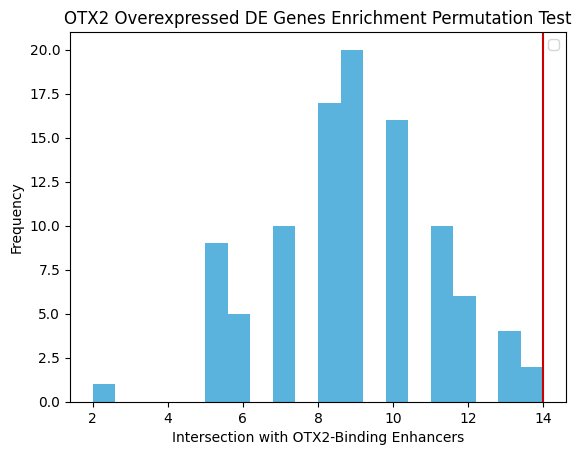

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Extract genes from OTX2_sigs dataframe
all_genes = set(tfs_df['Gene'])

# Only consider otx2_genes that are also present in tfs_df
otx2_genes = final_common_genes

# Check sizes to debug
print(f"Size of otx2_genes: {len(otx2_genes)}")
print(f"Size of all_genes: {len(all_genes)}")

# 1. Overlay the otx2_genes with the tfs_df network
# 2. Count the number of unique modules with "OTX2" as a TF and associated with otx2_genes
otx2_modules_hit = tfs_df[(tfs_df['TF'] == 'OTX2') & (tfs_df['Gene'].isin(otx2_genes))]['Module'].unique()
observed_count = len(otx2_modules_hit)

# 3. Randomly sample genes 100 times and count the hits
random_counts = []

for _ in range(100):
    sampled_genes = np.random.choice(list(all_genes), size=len(otx2_genes), replace=False)
    sampled_modules_hit = tfs_df[(tfs_df['TF'] == 'OTX2') & (tfs_df['Gene'].isin(sampled_genes))]['Module'].unique()
    random_counts.append(len(sampled_modules_hit))

# 4. Calculate FDR based on the observed count and the distribution of random counts
p_value = sum([1 for count in random_counts if count >= observed_count]) / 100
FDR = p_value

print(f"Observed module count: {observed_count}")
print(f"Mean module count from random samples: {np.mean(random_counts)}")
print(f"FDR: {FDR:.4f}")

# Plot Histogram of Random Instance Hits
fig, ax = plt.subplots()
ax.hist(random_counts, bins=20, color='#59B3DC')
ax.axvline(x=observed_count, color='#cc0000', linestyle='-')
ax.set_xlabel('Intersection with OTX2-Binding Enhancers')
ax.set_ylabel('Frequency')
ax.set_title('OTX2 Overexpressed DE Genes Enrichment Permutation Test')
ax.legend()
plt.show()

In [93]:
# Step 1: Find modules where OTX2 is a TF
otx2_modules = tfs_df[tfs_df['TF'] == 'OTX2']

# Step 2 & 3: Determine genes downstream of OTX2 and filter to only include final_common_genes
otx2_module_counts = otx2_modules[otx2_modules['Gene'].isin(final_common_genes)].groupby('Module').size()

# Step 4: Rank modules based on the number of affected genes they contain
ranked_modules = otx2_module_counts.sort_values(ascending=False)

# Display the top enhancer (module) and the number of OTX2 affected genes downstream
top_enhancer, top_count = ranked_modules.index[0], ranked_modules.iloc[0]
print(f"Top OTX2-binding enhancer (module): {top_enhancer}")
print(f"Number of OTX2 affected genes downstream: {top_count}")

# If you want to see which genes are in this enhancer/module:
genes_in_top_enhancer = otx2_modules[(otx2_modules['Module'] == top_enhancer) & otx2_modules['Gene'].isin(final_common_genes)]['Gene'].unique()
print(f"Genes in top enhancer: {genes_in_top_enhancer}")

Top OTX2-binding enhancer (module): Module_34517
Number of OTX2 affected genes downstream: 9
Genes in top enhancer: ['PPP1R9A' 'PEG10']


In [98]:
# Filtering the dataframe for the given module
module_data = tfs_df[tfs_df['Module'] == 'Module_34517']

# Fetching the unique TFs that bind to the module
binding_tfs = module_data['TF'].unique()

# Fetching the genes regulated by this module
regulated_genes = module_data['Gene'].unique()

binding_tfs, regulated_genes


(array(['RREB1', 'EGR3', 'WT1', 'RELA', 'ZNF263', 'KLF15', 'SP9', 'ZNF148',
        'ZBTB7B', 'TFAP2A', 'HIC1', 'PAX4', 'ZNF384', 'PTF1A', 'SOX1',
        'DNMT1', 'ZBTB4', 'CR936877.3', 'PURA', 'VDR', 'ENSG00000250096',
        'ETV5', 'ENSG00000235187', 'ETS1', 'KLF4', 'MAZ', 'PAX6', 'ZNF219',
        'RARG', 'NPAS3', 'ZFP161', 'KLF14', 'ELF1', 'ZNF589', 'SMAD1',
        'NHLH2', 'TRIM28', 'ESR2', 'NR2F2', 'PLAG1', 'ZBTB7C', 'FOXP4',
        'BCL6', 'SPZ1', 'ZNF683', 'E2F6', 'MYOD1', 'NR0B1', 'CTCF', 'ZFY',
        'PRDM1', 'E2F3', 'ATF3', 'ETV6', 'FOXD1', 'PLAGL1', 'ZSCAN4',
        'MAFA', 'TCF4', 'SOX11', 'TAL2', 'TLX3', 'CTCFL', 'SOX9', 'TFAP4',
        'IRF8', 'INSM1', 'MYC', 'IRF4', 'SP5', 'ZNF232', 'HINFP', 'ZNF143',
        'ZIC4', 'E2F1', 'SCRT2', 'CNOT3', 'ATF1', 'ZNF740', 'MBD2', 'THRB',
        'SREBF2', 'PITX2', 'ZNF524', 'THAP1', 'REST', 'RFX8', 'MAX',
        'SCRT1', 'ZNF282', 'USF2', 'NFIA', 'NANOGP1', 'SOX18', 'T',
        'NR2C2', 'EGR1', 'EP300', 'TFAP2', 'BHLHE40